In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf 
from tensorflow.keras import backend
from tensorflow.keras import layers

import numpy as np
import pandas as pd

import time
from datetime import timedelta

import math
import os

import scipy.misc
from scipy.stats import itemfreq
from random import sample
import pickle

import PIL.Image
from IPython.display import display

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from zipfile import ZipFile
from io import BytesIO

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt

In [4]:
tf.__version__

'2.0.0-beta1'

In [5]:
def absoluteFilePaths(directory):
    list_of_files = []
    dict_of_files={}
    for dirpath, _, filenames in os.walk(directory):
        for f in filenames:
            list_of_files.append(os.path.abspath(os.path.join(dirpath, f)))
            dict_of_files.setdefault(f.replace('.jpg', ''), os.path.abspath(os.path.join(dirpath, f)))

    return list_of_files, dict_of_files

In [6]:
file_names,file_dict = absoluteFilePaths('/home/umang.mittal/dogs/train/')
# test_file_names = absoluteFilePaths('/home/umang.mittal/dogs/test/')
working_dir = os.getcwd()

In [68]:
labels_raw = pd.read_csv("dogs/labels.csv", header=0, sep=',', quotechar='"')

In [8]:
def conversion(raw_data):
    return_dict = dict()
    for index, row in raw_data.iterrows():
        return_dict.setdefault(row[1], []).append(row[0])
    return return_dict

label_dict = conversion(labels_raw)

In [6]:

# This function help to create  a pickle file gathering all the image from a zip folder
def DataBase_creator(file_paths, nwidth, nheight, save_name):
    s = (len(file_paths), nwidth, nheight, 3)
    allImage = np.zeros(s)
    for i in range(0, len(file_paths)):
        image = PIL.Image.open(file_paths[i]) 
        image = image.resize((nwidth, nheight))
        image = np.array(image)
        image = np.clip(image / 255.0, 0.0, 1.0)
        allImage[i] = image
    pickle.dump(allImage, open(save_name + '.p', "wb"))

## Code for Data Augmentation using GANs

In [10]:
BUFFER_SIZE = 1
BATCH_SIZE = 256

In [11]:
def make_generator_model():
    model = tf.keras.Sequential()

    model.add(layers.Dense(7*7*768, use_bias=False, input_shape=(256,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 768)))
    assert model.output_shape == (None, 7, 7, 768) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(384, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 384)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(192, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 192)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 3)

    return model

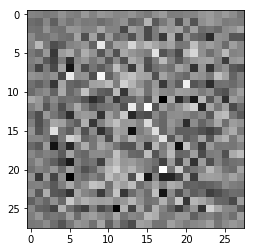

In [12]:
generator = make_generator_model()

noise = tf.random.normal([1,256])

generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [13]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [14]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00458491]], shape=(1, 1), dtype=float32)


In [15]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [16]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [17]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [18]:
generator_optimizer = tf.keras.optimizers.Adam(1e-3)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-3)

In [19]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [20]:
EPOCHS = 50
noise_dim = 256
num_examples_to_generate = 50

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [21]:

@tf.function
def train_step(images):
    
    noise = tf.random.normal([BATCH_SIZE, noise_dim])


    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    

In [22]:
generated_file_dict = {}
def train_gans(dataset, epochs,breed):
    
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

    predictions = generator(seed, training=False)
    fig = plt.figure(figsize=(4,4))
    
    breed_dict = {}
    
    for i in range(predictions.shape[0]):
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
        
        file_name = 'image_generated_{:04d}'.format(i)
        path = working_dir+'/dogs/train/'+breed+'/'+file_name+'.jpg'
        plt.savefig(path)
        breed_dict.setdefault(file_name,path)
        generated_file_dict.setdefault(breed,breed_dict)
    

In [23]:
def get_file_path(key):
    file_paths=[]
    for label in label_dict.get(key):
        file_paths.append(file_dict.get(label))
    return file_paths


In [ ]:
image_resize = 28

for key in label_dict.keys():
    DataBase_creator(file_paths = get_file_path(key), nwidth = image_resize, nheight = image_resize , save_name = "train_"+key)
    train = pickle.load(open('train_'+key+'.p',"rb")).astype('float32')
    train = (train - 127.5) / 127.5
    train_dataset = tf.data.Dataset.from_tensor_slices(train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    train_gans(train_dataset,EPOCHS,key)
  


W0712 13:23:40.910890 140013339109184 deprecation.py:323] From /home/umang.mittal/.local/lib/python2.7/site-packages/tensorflow/python/ops/nn_impl.py:182: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [70]:
# Block to update label_raw with new files and breed

for breed in generated_file_dict.keys():
    for value in generated_file_dict.get(breed).keys():
        labels_raw = labels_raw.append({"breed":breed,"id":value},ignore_index=True)

In [7]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

W0713 05:15:10.630295 140537321613120 deprecation.py:323] From /home/umang.mittal/.local/lib/python2.7/site-packages/tensorflow/python/compat/v2_compat.py:65: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term


In [8]:
config = tf.ConfigProto(intra_op_parallelism_threads=8, inter_op_parallelism_threads=8, \
                        allow_soft_placement=True, device_count = {'CPU': 8})
session = tf.Session(config=config)

In [9]:
tf.__version__

'2.0.0-beta1'

In [10]:
# labels_raw.to_csv('./new_labels.csv',index=False)
labels_raw = pd.read_csv("./new_labels.csv", header=0, sep=',', quotechar='"')

In [11]:
image_resize = 28


In [12]:
file_names,file_dict = absoluteFilePaths('/home/umang.mittal/dogs/train/')
test_file_names,test_dict = absoluteFilePaths('/home/umang.mittal/dogs/test/')

In [13]:
len(file_names)

16222

In [14]:
DataBase_creator(file_paths = file_names, nwidth = image_resize, nheight = image_resize , save_name = "train")
DataBase_creator(file_paths = test_file_names, nwidth = image_resize, nheight = image_resize , save_name = "test")

In [15]:
train = pickle.load( open( "train.p", "rb" ) )
test = pickle.load( open( "test.p", "rb" ) )

In [16]:
labels = labels_raw["breed"].as_matrix()
labels = labels.reshape(labels.shape[0],1) #labels.shape[0] looks faster than using len(labels)
labels.shape

(16222, 1)

In [17]:
def matrix_Bin(labels):
    labels_bin=np.array([])

    labels_name, labels0 = np.unique(labels, return_inverse=True)
    labels0
    
    for _, i in enumerate(itemfreq(labels0)[:,0].astype(int)):
        labels_bin0 = np.where(labels0 == itemfreq(labels0)[:,0][i], 1., 0.)
        labels_bin0 = labels_bin0.reshape(1,labels_bin0.shape[0])

        if (labels_bin.shape[0] == 0):
            labels_bin = labels_bin0
        else:
            labels_bin = np.concatenate((labels_bin,labels_bin0 ),axis=0)

    print("Nber SubVariables {0}".format(itemfreq(labels0)[:,0].shape[0]))
    labels_bin = labels_bin.transpose()
    print("Shape : {0}".format(labels_bin.shape))
    
    return labels_name, labels_bin

In [18]:
labels_name, labels_bin = matrix_Bin(labels = labels)
labels_bin[0:9]

Nber SubVariables 120
Shape : (16222, 120)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [19]:
num_validation = 0.30
train_test_split = X_train, X_validation, y_train, y_validation = train_test_split(train, labels_bin, test_size=num_validation, random_state=6)

In [20]:
def train_test_creation(x, data, toPred): 
    indices = sample(range(data.shape[0]),int(x * data.shape[0])) 
    indices = np.sort(indices, axis=None) 

    index = np.arange(data.shape[0]) 
    reverse_index = np.delete(index, indices,0)

    train_toUse = data[indices]
    train_toPred = toPred[indices]
    test_toUse = data[reverse_index]
    test_toPred = toPred[reverse_index]

    return train_toUse, train_toPred, test_toUse, test_toPred

df_train_toUse, df_train_toPred, df_test_toUse, df_test_toPred = train_test_creation(0.7, train, labels_bin)

df_validation_toPred_cls = np.argmax(y_validation, axis=1)
df_validation_toPred_cls[0:9]

array([  3,  41,  38,  56, 112,  34, 115,  50,  79])

In [21]:
img_size = image_resize
num_channels = 3
img_size_flat = img_size * img_size
img_shape = (img_size, img_size, num_channels)
num_classes = 120

def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))


def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))


In [22]:
def new_conv_layer(input,              
                   num_input_channels, 
                   filter_size,        
                   num_filters,        
                   use_pooling=True,
                   use_dropout=True):  


    shape = [filter_size, filter_size, num_input_channels, num_filters]


    weights = new_weights(shape=shape)


    biases = new_biases(length=num_filters)

    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')
    layer += biases
    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    layer = tf.nn.relu(layer)
    
    if use_dropout:
        layer = tf.nn.dropout(layer,keep_prob_conv)
    return layer, weights

In [23]:
def flatten_layer(layer):

    layer_shape = layer.get_shape()

    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])

    return layer_flat, num_features

In [24]:
def new_fc_layer(input,          
                 num_inputs,     
                 num_outputs,    
                 use_relu=True,
                 use_dropout=True):

    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)
    layer = tf.matmul(input, weights) + biases


    if use_relu:
        layer = tf.nn.relu(layer)
    
    if use_dropout:
        layer = tf.nn.dropout(layer,keep_prob_fc)
        
    return layer

In [25]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels]) 
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)
keep_prob_fc=tf.placeholder(tf.float32)
keep_prob_conv=tf.placeholder(tf.float32)

In [26]:

filter_size1 = 5          
num_filters1 = 32         



filter_size2 = 4          
num_filters2 = 64      



filter_size3 = 3       
num_filters3 = 128     


fc_size = 500 

layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True,
                   use_dropout=False)
    
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True,
                   use_dropout=False)
    
layer_conv3, weights_conv3 = \
    new_conv_layer(input=layer_conv2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   use_pooling=True,
                   use_dropout=True)

layer_flat, num_features = flatten_layer(layer_conv3)


layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True,
                         use_dropout=True)

layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False,
                         use_dropout=False)


y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, axis=1)

W0713 05:17:24.704636 140537321613120 deprecation.py:506] From <ipython-input-22-3f910d0a0dbb>:31: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [36]:
y_pred_cls

<tf.Tensor 'ArgMax_1:0' shape=(?,) dtype=int64>

In [27]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2, labels=y_true)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

W0713 05:17:24.763304 140537321613120 deprecation.py:323] From <ipython-input-27-23540ee58a4e>:1: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [28]:

def init_variables():
    session.run(tf.global_variables_initializer())

In [29]:
batch_size = 50


def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]


    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [30]:
def optimize(num_iterations, output_divisor):
    global total_iterations

    start_time = time.time()
    losses = {'train': [], 'validation': []}

    for i in range(num_iterations):
        total_iterations += 1
        x_batch, y_true_batch = next_batch(batch_size, X_train, y_train)

        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch,
                           keep_prob_conv: 0.3,
                           keep_prob_fc: 0.4}
        feed_dict_validation = {x: X_validation,
                                y_true: y_validation,
                                keep_prob_conv: 1,
                                keep_prob_fc: 1}

        session.run(optimizer, feed_dict=feed_dict_train)

        acc_train = session.run(accuracy, feed_dict=feed_dict_train)
        acc_validation = session.run(accuracy, feed_dict=feed_dict_validation)
        losses['train'].append(acc_train)
        losses['validation'].append(acc_validation)

        if (total_iterations % output_divisor == 0) or (i == (num_iterations - 1)):
            msg = "Iteration: {0:>6}, Training Accuracy: {1:>6.1%}, Validation Accuracy: {2:>6.1%}"
            print(msg.format(total_iterations, acc_train, acc_validation))

    end_time = time.time()

    time_dif = end_time - start_time
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

    plt.plot(losses['train'], label='Training loss')
    plt.plot(losses['validation'], label='Validation loss')
    plt.legend()
    _ = plt.ylim()

In [ ]:
init_variables()
total_iterations = 0
optimize(num_iterations=10000, output_divisor=250)

Iteration:    250, Training Accuracy:   0.0%, Validation Accuracy:   0.8%
Iteration:    500, Training Accuracy:   6.0%, Validation Accuracy:   0.7%
Iteration:    750, Training Accuracy:   0.0%, Validation Accuracy:   1.1%
Iteration:   1000, Training Accuracy:   0.0%, Validation Accuracy:   0.8%
Iteration:   1250, Training Accuracy:   0.0%, Validation Accuracy:   1.0%
Iteration:   1500, Training Accuracy:   2.0%, Validation Accuracy:   1.0%
Iteration:   1750, Training Accuracy:   2.0%, Validation Accuracy:   1.2%
Iteration:   2000, Training Accuracy:   0.0%, Validation Accuracy:   1.0%
Iteration:   2250, Training Accuracy:   2.0%, Validation Accuracy:   0.8%
Iteration:   2500, Training Accuracy:   0.0%, Validation Accuracy:   0.8%
Iteration:   2750, Training Accuracy:   0.0%, Validation Accuracy:   0.8%
Iteration:   3000, Training Accuracy:   2.0%, Validation Accuracy:   0.8%
Iteration:   3250, Training Accuracy:   2.0%, Validation Accuracy:   1.2%
Iteration:   3500, Training Accuracy: 

In [37]:
all_vars=tf.global_variables()

In [38]:

# Add ops to save and restore all the variables.
saver = tf.train.Saver(all_vars)

save_path = saver.save(session, "/home/umang.mittal/Where-s-Spot/myproject/wherespot/recon_model3.ckpt")

In [96]:
feed_dict_validation = {x: X_validation, y_true: y_validation, keep_prob_conv : 1, keep_prob_fc : 1}
df_validation_Predicted_cls = session.run(y_pred_cls, feed_dict=feed_dict_validation)

In [97]:
print(type(X_validation))

<type 'numpy.ndarray'>
